# Multiple Linear Regression

In this notebook are some exercises to gain more experience with the material presented in the Multiple Linear Regression lecture. You'll get some practice fitting models, and gain a stronger theoretical understanding of the technique as well. We'll also introduce some new important concepts that weren't explicitly covered in the lecture.

In [2]:
# import the packages we'll use
## For data handling
import pandas as pd
import numpy as np
from numpy import meshgrid

## For plotting
import matplotlib.pyplot as plt
import seaborn as sns

## This sets the plot style
## to have a grid on a white background
sns.set_style("whitegrid")

from pandas.plotting import scatter_matrix

import statsmodels.api as sm

## Theoretical Questions

##### 1. Gradient Descent

While we have the normal equation as the OLS estimate for $\hat{\beta}$ it is sometimes not ideal to to use that equation to find the estimate. This is because if there are too many features it can be computationally costly to perform the inverse operation.

One alternative to the normal equation is to perform gradient descent.

Let $\ell(\beta)$ denote a loss function. 

If we remember some Calculus III we'll remember that for a particular value of $\beta$, say $\beta^*$, the direction of greatest descent for $\ell$ at $\beta^*$, i.e. how to get to the minimum of $\ell$ most quickly from $\beta^*$, is the opposite direction of the gradient, $-\nabla \ell(\beta^*)$. You can thus approach the value of $\beta$ that minimizes $\ell$ by iteratively updating $\beta$ by moving in $\alpha$ sized steps in the direction of greatest descent.

Write out an algorithm (in mathematical symbols not code) that leverages the gradient of the loss function to find the optimal $\hat{\beta}$ for multiple linear regression.

### ANSWER

Recall that for multiple linear regression $\ell(\beta) = \frac{1}{n}(y-X\beta)^T(y-X\beta)$. Thus
$$
\nabla \ell(\beta) = \frac{2}{n}\left(X^TX\beta - X^Ty\right).
$$

Thus we can run an iterative algorithm like so:
Make an initial random guess at $\hat{\beta}$ and call is $\beta^{(0)}$. For each step:
$$
\beta^{(i+1)} = \beta^{(i)} - \alpha \frac{2}{n}\left(X^TX\beta - X^Ty\right),
$$
for some $\alpha \in \mathbb{R}^{+}$ (this is called the learning rate).

Note that as long as our learning rate isn't too large this is guaranteed to converge to the optimal estimate of $\beta$.

##### 2. Statistical Significance of the Model

One kind of explanatory modeling question we may be interested in is whether or not the model is statistically significant. Assuming that we have $m$ features this corresponds to the following hypothesis test:
$$
\text{H}_0: \beta_1 = \beta_2 = \dots = \beta_m \text{ vs.}
$$

$$
\text{H}_1: \text{ at least one of } \beta_i \neq 0.
$$
This test allows you to say whether any of your predictors are significantly associated with the target $y$, when compared to the baseline model of $y=E(y)$. In non-statistical terms we're asking the question: "Does my regression model contain at least one feature that helps explain what I see in the target variable?"

Let's see how we can perform this test using `statsmodels`.

Suppose I fit a multiple linear regression for the following data:

In [2]:
X = np.random.randn(100,2)
y = 2 + 3*X[:,0] + np.random.randn(100) 

In [3]:
fit = sm.OLS(y, sm.add_constant(X)).fit()

print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.907
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                     471.9
Date:                Sat, 03 Oct 2020   Prob (F-statistic):           1.04e-50
Time:                        11:32:53   Log-Likelihood:                -137.07
No. Observations:                 100   AIC:                             280.1
Df Residuals:                      97   BIC:                             288.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.9121      0.097     19.685      0.0

Let's take a closer look at the table.

<img src = "F_stat.png" style="width:60%"></img>

The circled portion of the table is the $F$-statistic of the above hypothesis test and the $p$-value associated with said test. As we should expect here the $p$-value is incredibly low meaning that we would reject the null hypothesis in favor of the alternative.

Now return to the beer data and use `statsmodels` to fit a multiple linear regression for the following model:
$$
\text{IBU} = \beta_0 + \beta_1 \text{ABV} + \beta_2 \text{Stout} + \beta_3 \text{Stout} \times \text{ABV}.
$$

Perform the above hypothesis test and interpret the results.

In [3]:
## Code here or write here
beers = pd.read_csv("beer.csv")

beers['Stout'] = pd.get_dummies(beers['Beer_Type'])['Stout']
beers['Stout_ABV'] = beers['Stout']*beers['ABV']

fit = sm.OLS(beers['IBU'], 
                 sm.add_constant(beers[['ABV','Stout','Stout_ABV']])).fit()

print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:                    IBU   R-squared:                       0.493
Model:                            OLS   Adj. R-squared:                  0.489
Method:                 Least Squares   F-statistic:                     111.3
Date:                Sun, 25 Apr 2021   Prob (F-statistic):           2.39e-50
Time:                        16:48:53   Log-Likelihood:                -1478.1
No. Observations:                 347   AIC:                             2964.
Df Residuals:                     343   BIC:                             2980.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.4825      6.010      1.744      0.0

The $p$-value associated with the hypothesis test is $2.39\times 10^{-50}$, which is incredibly small. This means that we would reject the null hypothesis in favor of the alternative. There is very strong statistical evidence that one of $\text{ABV}$, $\text{Stout}$, of the interaction has a linear association with $\text{IBU}$.

##### 3. The General Linear $F$-Test or Partial $F$-Test

The statistical test we showed in problem 2. is not all that useful for determining if specific variables are useful for explaining the variance we see in the target data.

You can always perform a hypothesis test for a single coefficient ($\text{H}_0: \beta_i = 0$ vs. $\text{H}_1: \beta_i \neq 0$) by examining the confidence interval associated with that coefficient. If the interval contains $0$ you know that the variable is not statistically significant at that confidence level (standard level is $95\%$).

Another test you may wish to perform is the General Linear $F$-Test (also called partial $F$-Test). In this test you are asking the question "Is my target related to this collection of variables?". For example suppose you're interested in testing $\beta_3$, $\beta_4$, and $\beta_5$:
$$
\text{H}_0: \beta_3 = \beta_4 = \beta_5 = 0 \text{ vs.}
$$

$$
\text{H}_1: \text{ at least one of } \beta_i, \ i = 3,4,5 \text{ are nonzero}
$$

This test is useful when you're interested in the effects of a categorical variable with more than one category. In that setting you can't just test if one of the categories has a significant effect, you must test all categories concurrently. Thus the confidence interval procedure mentioned above doesn't work.

In order to perform this test you need two models, a <i>full model</i> that must at least contain the variables you're interested in testing, and a <i>reduced model</i> that is the full model with the variables you're interested in removed.

We'll now show how to do this test with `statsmodels`. 

For this example the full model is:
$$
y = \beta_0 + \beta_1 x_1 + \beta_2 \text{a} + \beta_2 \text{b}.
$$

The reduced model is:
$$
y = \beta_0 + \beta_1 x_1.
$$

In [4]:
# Here I create some fake data
X = np.zeros((600,2))
np.random.seed(440)

# The first column is a continuous feature
X[:,0] = 2*np.random.randn(600)-1

# The second is categorical
X[:200,1] = 1
X[200:400,1] = 2
X[400:,1] = 3

# y = 1 + 2x_1 + - 2*1_{x_2 == 1} + epsilon
y = 1 + 2*X[:,0] + np.random.randn(600)
y[X[:,1] == 1] = y[X[:,1] == 1] - 2

In [5]:
# Now I put it in a dataframe
df = pd.DataFrame({'y':y,'x1':X[:,0],'x2':X[:,1]})

df.loc[df.x2 == 1,'x2'] = 'a'
df.loc[df.x2 == 2,'x2'] = 'b'
df.loc[df.x2 == 3,'x2'] = 'c'

# Make dummy variables
df[['a','b']] = pd.get_dummies(df['x2'])[['a','b']]

In [6]:
# First you fit the full model
fit = sm.OLS(df['y'],sm.add_constant(df[['x1','a','b']])).fit()

# Then we type out the specific hypothesis we're
# testing for the reduced model as a string
hypotheses = 'a=b=0'

# You can then call the f_test with that hypothesis
f_test = fit.f_test(hypotheses)

print("The F-statistic is",f_test.fvalue, 
      "which has an associate p-value of", f_test.pvalue)


The F-statistic is [[244.13578899]] which has an associate p-value of 3.566476961458313e-78


The results of this test inform us that there is very strong statistical evidence of the categorical variable having an effect on the target `y`. Thus it would be wise to leave it in the model for explanatory purposes.

Return to the `carseats` data set and build a full model that includes the `ShelveLoc` variable. Then perform a partial $F$-test to see if there is evidence that shelve location has an effect on `Sales`.

In [7]:
## Code here or write here
carseats = pd.read_csv("carseats.csv")
carseats[['Good','Bad']] = pd.get_dummies(carseats['ShelveLoc'])[['Good','Bad']]


# Sales ~ Price + Advertising + Age + ShelveLoc
full_fit = sm.OLS(carseats['Sales'],
                 sm.add_constant(carseats[['Price','Advertising',
                                           'Age','Good','Bad']])).fit()



print(full_fit.summary())


hypothesis = 'Good=Bad=0'

f_test = full_fit.f_test(hypothesis)

print("The F-statistic is",f_test.fvalue, 
      "which has an associate p-value of", f_test.pvalue)

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.690
Model:                            OLS   Adj. R-squared:                  0.686
Method:                 Least Squares   F-statistic:                     175.0
Date:                Sun, 25 Apr 2021   Prob (F-statistic):           1.00e-97
Time:                        16:49:16   Log-Likelihood:                -748.40
No. Observations:                 400   AIC:                             1509.
Df Residuals:                     394   BIC:                             1533.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          16.4100      0.510     32.194      

Given the low $p$-value of the partial $F$-test it appears that there is strong evidence of Shelf Location having an effect on the Sales of carseats.

##### 4. Sum of Squares Table

Recall that the goal of explanatory modeling is to help explain the target data. This means trying to explain the variance of the target data.

One way we can examine this is by looking at the <i>Sum of Squares Table</i>.

Recall the variance of $y$ is how much it deviates from $\overline{y}$, i.e.
$$
\sum_{i=1}^n \left(y_i - \overline{y}\right)^2 = \text{SST},
$$
the total sum of squares, it can be shown that:
$$
\text{SST} = \sum_{i=1}^n \left(\hat{y}_i - \overline{y} \right)^2 + \sum_{i=1}^n\left(\hat{y}_i - y_i\right)^2 = \text{SSM} + \text{SSR},
$$
where $\text{SSM}$ denotes the model sum of squares and $\text{SSR}$ denotes the residual sum of squares.

Note the $\text{SSR}$ is $n \text{MSE}$, and thus estimates $\sigma^2$. The $\text{SSM}$ term estimates the variance in $y$ that is explained by the model.

Further, for multiple linear regression $\text{SSM}$ can be broken down into contributions to the variance from each individual variable.

Let's demonstrate how to get the sum of squares table using `statsmodels`.


In [8]:
# Here I create some fake data
np.random.seed(440)
X = np.zeros((600,2))

# The first column is a continuous feature
X[:,0] = 2*np.random.randn(600)-1

# The second is categorical
X[:200,1] = 1
X[200:400,1] = 2
X[400:,1] = 3

# y = 1 + 2x_1 + - 2*1_{x_2 == 1} + epsilon
y = 1 + 2*X[:,0] + np.random.randn(600)
y[X[:,1] == 1] = y[X[:,1] == 1] - 2

In [9]:
# Now I put it in a dataframe
df = pd.DataFrame({'y':y,'x1':X[:,0],'x2':X[:,1]})

df.loc[df.x2 == 1,'x2'] = 'a'
df.loc[df.x2 == 2,'x2'] = 'b'
df.loc[df.x2 == 3,'x2'] = 'c'

# Make dummy variables
df[['a','b']] = pd.get_dummies(df['x2'])[['a','b']]

In [10]:
# First you fit the model
# note that we use ols instead of sm.OLS
from statsmodels.formula.api import ols

# for ols you write the regression formula
# as a string
fit = ols('y ~ x1 + a + b', df).fit()


sm.stats.anova_lm(fit)

,df,sum_sq,mean_sq,F,PR(>F)
x1,1.0,9821.083158,9821.083158,9566.082414,0.000000e+00
a,1.0,500.690058,500.690058,487.689829,2.033895e-79
b,1.0,0.597257,0.597257,0.581749,4.459292e-01
Residual,596.0,611.887428,1.026657,NaN,NaN


In the above table you can sum up the `sum_sq` column to get $\text{SST}$. Each entry in the `sum_sq` column is that variable's (or the residual's) contribution to the $\text{SST}$.

<b>Note: Sums of squares are quite susceptible to the scale of the data. So a variable with a very large scale (say the 1000s) may seem more important than another variable with a very small scale (say 1/10s). Thus it is important to scale your data before fitting the model.</b>

Return to the `beer` data, then create the sum of squares table for the following model:
$$
\text{IBU} = \beta_0 + \beta_1 \text{ABV} + \beta_2 \text{Stout} + \beta_3 \text{ABV} \times \text{Stout} + \epsilon.
$$

In [11]:
## Code here or write here
beer = pd.read_csv("beer.csv")

beer['Stout'] = pd.get_dummies(beer['Beer_Type'])['Stout']

In [12]:
## Code here or write here
# Here's a fun feature, I don't actually have to create the 
# interaction term for ols
fit = ols('IBU ~ ABV + Stout + Stout*ABV',beer).fit()

print(fit.summary())

print()
print("SUM OF SQUARES TABLE")
print(sm.stats.anova_lm(fit))









                            OLS Regression Results                            
Dep. Variable:                    IBU   R-squared:                       0.493
Model:                            OLS   Adj. R-squared:                  0.489
Method:                 Least Squares   F-statistic:                     111.3
Date:                Sun, 25 Apr 2021   Prob (F-statistic):           2.39e-50
Time:                        16:49:34   Log-Likelihood:                -1478.1
No. Observations:                 347   AIC:                             2964.
Df Residuals:                     343   BIC:                             2980.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.4825      6.010      1.744      0.0

##### 5. Interpreting Interaction Terms.

Look at the model you just fit for the `beer` data. Try to interpret the estimates of the various coefficients.

I can use the table from the solution for number 4.

We would say that our model estimates an IPA beer with $0$ ABV would have an IBU of $\hat{\beta_0}=10.4825$. Our model estimates that a Stout beer with $0$ ABV would have an IBU of $\hat{\beta_0} + \hat{\beta_2} = 10.4825 - 2.2906 = 8.1919$.

For IPAs we estimate that a $1$ unit increase in ABV results in a $\hat{\beta_1}=7.9806$ unit increase in IBU. While for Stouts we estimate that a $1$ unit increase in ABV results in a $\hat{\beta_1} + \hat{\beta_3} = 7.9806 - 3.5838 = 4.3968$ unit increase in IBU.

##### 6. Model Selection Algorithms

Here we'll describe two additional model selection algorithms.

##### Forwards Selection

Say you have $m$ predictors $X_1,\dots,X_m$, and a target $y$. 

Starting with an empty model you build $m$ simple linear regression models and then choose the one with lowest testing error (for instance by looking at the average cv error). Call this model $1$. 

Take model $1$ and go through the remaining $m-1$ features and add them one at a time to model $1$. This will give you $m-1$ two feature models. Look at the one with lowest testing error, call it model $2$. If model $2$ has lower testing error than model $1$ continue in this way and look at the remaining $m-2$ predictors. If model $1$ has the lower testing error you stop and model $1$ is the model you choose.

You continue until you either find a model with lowest testing error (for example if model $3$ had lower testing error than model $4$ you chose model $3$), or until you have built the model regressing $y$ on all of $X_1,\dots,X_m$.

##### Backwards Selection

This algorithm is sort of the opposite of forwards selection.

Again say you have $m$ predictors $X_1,\dots,X_m$ and a target $y$.

Starting with the model regressing $y$ on all of $X_1,\dots,X_m$, remove each of the $X_i$ predictors one at a time, regressing $y$ on the remaining $m-1$ features. If one of these models has lower testing error than the full model take it and call it model $1$. If none of those models has lower testing error than the full model stick with the full model.

Take model $1$ and remove each of the $m-1$ predictors one at a time, regressing $y$ on the remaining $m-2$ features. If one of those models has lower testing error than model $1$ take it and call it model $2$. If none of those models has lower testing error than model $1$ stick with model $1$.

Continue in this way until you have a reduced model with lowest testing error, or until you end up with the model with no predictors, i.e. $y = E(y)$.

###### Greedy Algorithms

These are both <i>greedy algorithms</i> because at each step you take the move that benefits you the most in the moment, but you don't explore suboptimal paths that may be better in the long run. While you may not get the best model, you're willing to go with a model that is close to correct in a faster time. Both of these algorithms at worst require fitting $m!$ models as opposed to the $2^m$ models required for the brute force approach.

#### The Problem

Choose one of either forwards or backwards selection and program the algorithm to build a model to predict `Sales` from the `Advertising` data.

##### ANSWER

I'll do forward selection.

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.base import clone

In [14]:
## Here I copy and paste the code for best subset selection:
# This gets our data for us
def get_X_y(df,features,target):
    # Returns X then y
    return np.array(df[features]), np.array(df[target])

# this calculates the mse
def get_mse(model, X, y):
    # get the prediction
    pred = model.predict(X)
    
    # Returns the mse
    return np.sum(np.power(pred-y,2))/len(y)

In [16]:
## read in the data
ads = pd.read_csv("Advertising.csv")

ads_train = ads.copy().sample(frac=.75, random_state = 440)
ads_test = ads.copy().drop(ads_train.index)

In [17]:
## Make the features we were interested in from class
ads_train['sqrt_TV'] = np.sqrt(ads_train['TV'])
ads_train['sqrtTV_radio'] = ads_train['sqrt_TV'] * ads_train['radio']

In [18]:
reg = LinearRegression(copy_X=True)
kfold = KFold(n_splits = 5, shuffle = True, random_state = 440)

In [19]:
# Get the mean cv MSE for a baseline model
# of y = sample mean of y
X,y = get_X_y(ads_train,'TV','sales')

cv_mses = []

for train_index, test_index in kfold.split(X):
    # Get the cv train test split
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    cv_mses.append(np.sum(np.power(y_test - np.mean(y_train),2))/len(y_test))
    
old_mse = np.mean(cv_mses)

possible_features = set(['TV','radio','newspaper','sqrt_TV','sqrtTV_radio'])
accepted_features = set([])

# initialize it
new_mse = old_mse
add = True

while (new_mse <= old_mse) & add:
    old_mse = new_mse
    add = False
    print("Current features are",accepted_features,
          "with mean cv mse of",old_mse)
    for feature in possible_features - accepted_features:
        X,y = get_X_y(ads_train,
                      list(accepted_features.union(set([feature]))),
                      'sales')
        #print(feature)
        
        # Perform CV
        cv_mses = []
        for train_index, test_index in kfold.split(X):
            # Get the cv train test split
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            # Cloning the regression makes a fresh regression 
            # model for each run
            clone_reg = clone(reg)

            # fit the model
            clone_reg.fit(X_train,y_train)

            cv_mses.append(get_mse(clone_reg, X_test, y_test))

        if np.mean(cv_mses) < new_mse:
            added_feature = feature
            new_mse = np.mean(cv_mses)
            add = True
    
    if add:
        accepted_features.add(added_feature)
        
print()

if not add:
    print("Stopped before adding all features")
    print("The model features I found were",accepted_features)
    print("They have a mean csv mse of",old_mse)

if len(possible_features) == len(accepted_features):
    print("Best model I found was the one with all features")

Current features are set() with mean cv mse of 26.23677416666667
Current features are {'sqrtTV_radio'} with mean cv mse of 3.804029886219756
Current features are {'sqrtTV_radio', 'sqrt_TV'} with mean cv mse of 0.2908370923369847
Current features are {'sqrtTV_radio', 'radio', 'sqrt_TV'} with mean cv mse of 0.23544852823802845
Current features are {'sqrtTV_radio', 'radio', 'sqrt_TV', 'TV'} with mean cv mse of 0.23394746333241123

Stopped before adding all features
The model features I found were {'sqrtTV_radio', 'radio', 'sqrt_TV', 'TV'}
They have a mean csv mse of 0.23394746333241123


## Applied Questions

##### 1. Gradient Descent in Action

Using your answer to question 1. under Theoretical Questions use `numpy` to perform gradient descent to fit the multiple linear regression model for the following data. <i>Note: If you didn't do that question, you can wait to try this one until after I provide solutions :)</i>

##### ANSWER

In [20]:
X = np.random.randn(5000,1000)

y = X.dot(np.random.randint(-5,5,1000)) + 2*np.random.randn(5000)

In [21]:
## Code here or write here
def get_mse(beta,X,y):
    return np.sum(np.power(y-X.dot(beta),2))/len(y)

def update(beta,X,y,alpha):
    return beta - alpha*2*(X.transpose().dot(X.dot(beta)) - X.transpose().dot(y))/len(y)

In [22]:
## Code here or write here
# Set the tolerance and stopping point
tol = 0.00001
n = 10000

# I'll use .25 as a learning rate
alpha = .25

# make a random initial guess
beta = np.random.randn(1000)

# calculate first mse
mse = [get_mse(beta,X,y)]

# initialize this
mse_diff = 10
i = 0


while (mse_diff > tol) and (i <= n):
    beta = update(beta,X,y,alpha)
    
    
    mse.append(get_mse(beta,X,y))
    
    mse_diff = np.abs(mse[i+1] - mse[i])
    
    i = i+1
    
if i > n:
    print("Reached Stopping point before convergence was achieved.")

if mse_diff <= tol:
    print("Found optimal beta within desired tolerance level.")

Found optimal beta within desired tolerance level.


Now compare the output of your code to the model you get using `SGDRegressor`, <a href="https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html">https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html</a>.

In [23]:
## Code here or write here
from sklearn.linear_model import SGDRegressor

sgd = SGDRegressor(tol = tol, max_iter = n)

In [24]:
## Code here or write here
sgd.fit(X,y)

SGDRegressor(max_iter=10000, tol=1e-05)

In [25]:
## Code here or write here
for i in range(10):
    print("Our hand coded sgd estimate of beta_" + str(i+1) + " was",beta[i])
    print("The SGDRegressor estimate of beta_" + str(i+1) + " was",sgd.coef_[i])
    print()

Our hand coded sgd estimate of beta_1 was 3.043866365706486
The SGDRegressor estimate of beta_1 was 3.0205280669906758

Our hand coded sgd estimate of beta_2 was -1.9684556031537959
The SGDRegressor estimate of beta_2 was -1.9807075617467984

Our hand coded sgd estimate of beta_3 was -0.02256388790442865
The SGDRegressor estimate of beta_3 was -0.015296661781325245

Our hand coded sgd estimate of beta_4 was 4.061297436182911
The SGDRegressor estimate of beta_4 was 4.056088975782353

Our hand coded sgd estimate of beta_5 was 2.0371567222886995
The SGDRegressor estimate of beta_5 was 2.0557102460265995

Our hand coded sgd estimate of beta_6 was -3.014522507273662
The SGDRegressor estimate of beta_6 was -2.9824921522048697

Our hand coded sgd estimate of beta_7 was 0.04369599437295785
The SGDRegressor estimate of beta_7 was 0.04644313057518156

Our hand coded sgd estimate of beta_8 was -4.9748758782651334
The SGDRegressor estimate of beta_8 was -4.947769562241704

Our hand coded sgd estim

##### 2. Build the Best Predictive Model You Can

Return to the data set from `PredictiveModelingAssessmentData.csv`. Use cross-validation to build the best predictive model you can to predict the `y` variable. As a hint theoretically the best you can do is a mean root mean square error of $1$.

##### ANSWER

In [26]:
## Code here or write here
df = pd.read_csv("PredictiveModelingAssessmentData.csv")

df_train = df.copy().sample(frac=.75,random_state=440)
df_test = df.copy().drop(df_train.index)

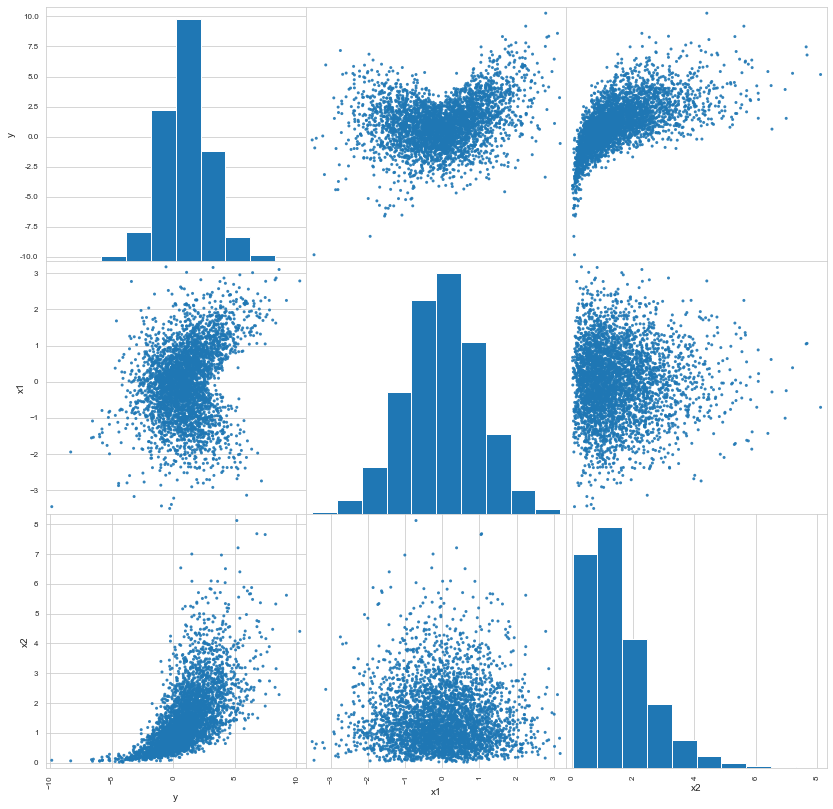

In [27]:
## Code here or write here
# Note that I edited the import statements at the top of the notebook 
# to include scatter matrix
scatter_matrix(df_train, figsize=(14,14), alpha=.9)

plt.show()

It looks like adding in $x_1^2$ and maybe $x_1^3$, $x_1^4$ may be helpful., Let's also take the $\log$ of $x_2$.

In [28]:
df_train['x1sq'] = df_train['x1']**2
df_train['x1cb'] = df_train['x1']**3
df_train['x1frth'] = df_train['x1']**4
df_train['logx2'] = np.log(df_train['x2'])
df_train['x1logx2'] = df_train['x1']*df_train['logx2']
df_train['x1sqlogx2'] = df_train['x1sq']*df_train['logx2']

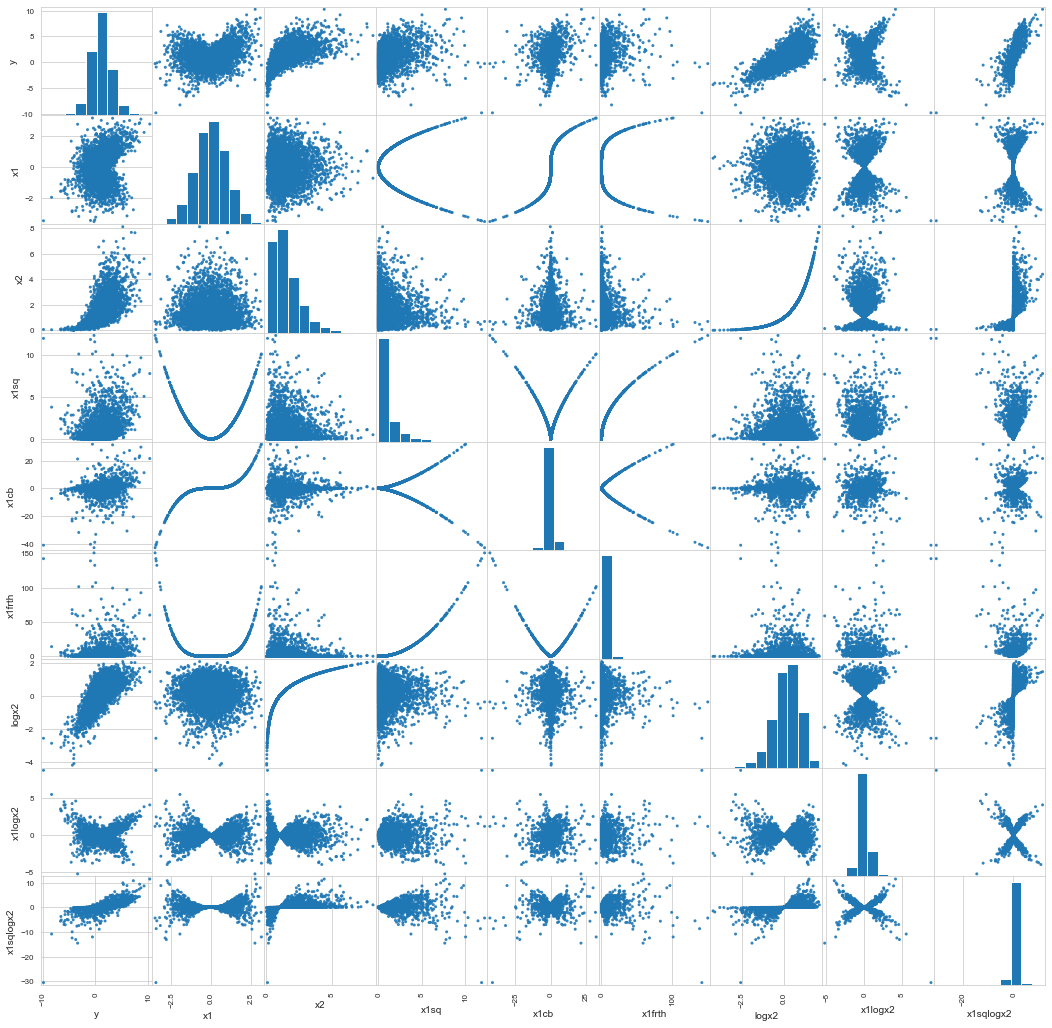

In [29]:
## Code here or write here
scatter_matrix(df_train, figsize=(18,18), alpha=.9)

plt.show()

In [30]:
## Here I copy and paste the code for best subset selection:
# This gets our data for us
def get_X_y(df,features,target):
    # Returns X then y
    return np.array(df[features]), np.array(df[target])

# this calculates the mse
def get_mse(model, X, y):
    # get the prediction
    pred = model.predict(X)
    
    # Returns the mse
    return np.sum(np.power(pred-y,2))/len(y)

# This returns the power set of a set minus the empty set
def powerset_no_empty(s):
    power_set = []
    x = len(s)
    for i in range(1 << x):
        power_set.append([s[j] for j in range(x) if (i & (1 << j))])
            
    return power_set[1:]

In [31]:
possible_features = powerset_no_empty(['x1','x2','x1sq','x1cb','x1frth','logx2','x1logx2','x1sqlogx2'])

In [32]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.base import clone

In [33]:
kfold = KFold(n_splits = 10, shuffle = True, random_state = 440)

In [34]:
# Now make an array that will hold the mses
# for all the models
# the columns represent each possible model
MSEs = np.empty((10,len(possible_features)))

In [35]:
# Make a regression model
reg = LinearRegression(copy_X = True)

In [36]:
# For each possible model
for j in range(len(possible_features)):
    # get X and y
    X, y = get_X_y(df_train, possible_features[j], 'y')

    # keep track of what split we're on
    i = 0
    
    # Perform CV
    for train_index, test_index in kfold.split(X):
        # Get the cv train test split
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Cloning the regression makes a fresh regression 
        # model for each run
        clone_reg = clone(reg)
        
        # fit the model
        clone_reg.fit(X_train,y_train)
        
        MSEs[i,j] = get_mse(clone_reg, X_test, y_test)
        
        i = i + 1

In [37]:
print("The model with the lowest mean CV RMSE",
     "was the one with", possible_features[np.argmin(np.mean(MSEs, axis = 0))],
     "as the features. This model had a mean CV RMSE of",
     np.round(np.min(np.mean(np.sqrt(MSEs), axis=0)),5))

The model with the lowest mean CV RMSE was the one with ['x1', 'x1sq', 'x1cb', 'x1frth', 'logx2', 'x1sqlogx2'] as the features. This model had a mean CV RMSE of 1.03589


Let's go with this model, but I'll also add in the interaction term $x_1 \log(x_2)$ because I like to respect hierarchical modeling.

In [38]:
reg.fit(df_train[['x1','x1sq','x1cb','x1frth','logx2','x1logx2','x1sqlogx2']],df_train['y'])

LinearRegression()

In [39]:
df_test['x1sq'] = df_test['x1']**2
df_test['x1cb'] = df_test['x1']**3
df_test['x1frth'] = df_test['x1']**4
df_test['logx2'] = np.log(df_test['x2'])
df_test['x1logx2'] = df_test['x1']*df_test['logx2']
df_test['x1sqlogx2'] = df_test['x1sq']*df_test['logx2']

In [40]:
pred = reg.predict(df_test[['x1','x1sq','x1cb','x1frth','logx2','x1logx2','x1sqlogx2']])

In [41]:
test_rmse = np.sqrt(get_mse(reg,
                np.array(df_test[['x1','x1sq','x1cb','x1frth','logx2','x1logx2','x1sqlogx2']]),
                np.array(df_test['y'])))

In [42]:
print("The test root mean square error for our model is", np.round(test_rmse,3))

The test root mean square error for our model is 1.016


This notebook was written for the Erd&#337;s Institute C&#337;de Data Science Boot Camp by Matthew Osborne, Ph. D., 2021.

Redistribution of the material contained in this repository is conditional on acknowledgement of Matthew Tyler Osborne, Ph.D.'s original authorship and sponsorship of the Erdős Institute as subject to the license (see License.md)